# Sentiment Analysis Notebook
This notebook walks through dataset loading, preprocessing, EDA, model training, evaluation, and deployment steps.

In [6]:
import sys
from pathlib import Path
# Ensure project root is on sys.path so `from src...` works when running this notebook from notebooks/
project_root = Path('..').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
from src.preprocessing import load_dataset, preprocess_df, split_data
from src.models import build_tfidf_vectorizer, train_logistic_regression, train_random_forest, evaluate_model, save_model

# Load data
# Prefer IMDB dataset if present, otherwise fall back to sample_sentiment.csv
imdb_path = project_root / 'data' / 'IMDB_Dataset.csv'
sample_path = project_root / 'data' / 'sample_sentiment.csv'
if imdb_path.exists():
    df = load_dataset(str(imdb_path))
    # IMDB has columns 'review' and 'sentiment' - normalize to 'text'/'label'
    if 'review' in df.columns and 'sentiment' in df.columns:
        df = df.rename(columns={'review': 'text', 'sentiment': 'label'})
else:
    df = load_dataset(str(sample_path))
print('Dataset shape:', df.shape)
display(df.head())

Dataset shape: (50000, 2)


,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Shape: (10, 2)
label
positive    4
negative    3
neutral     3
Name: count, dtype: int64


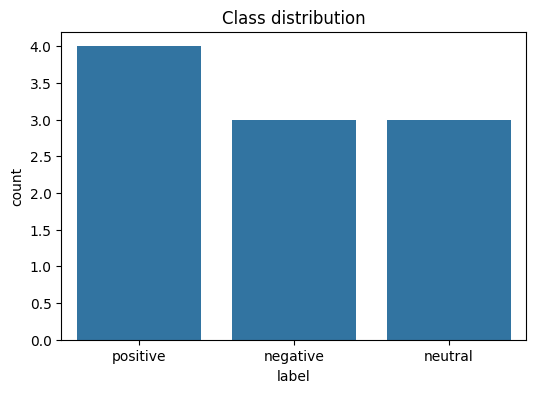

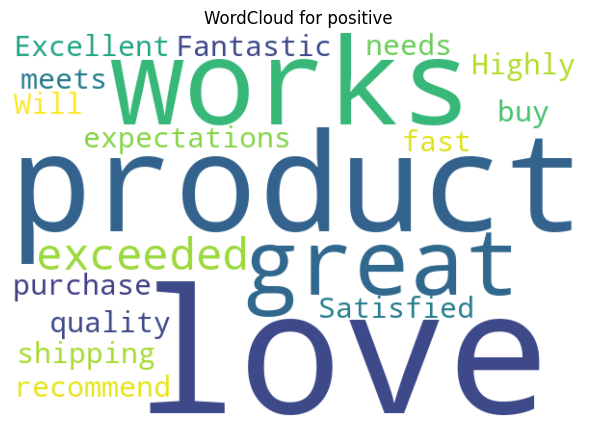

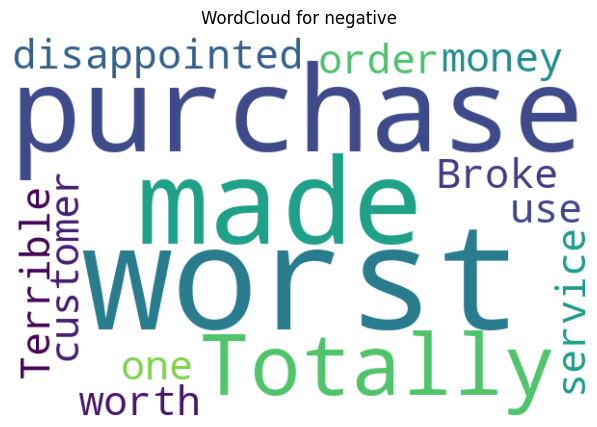

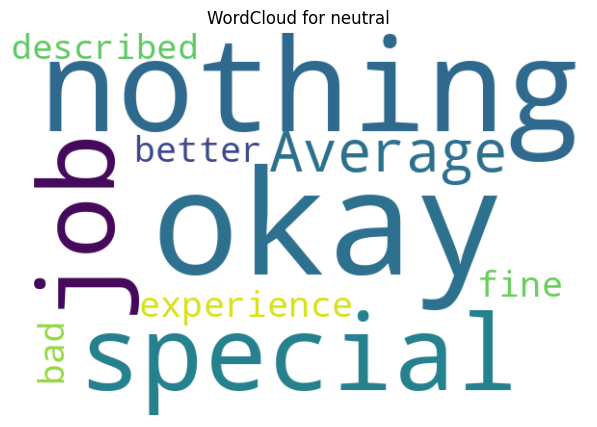

Train/Val/Test sizes: 7 1 2


C:\Users\user\Desktop\Study\4 course\Machine Learning\Final\src\preprocessing.py:53: UserWarning: Stratified split for test failed (too few samples per class). Using non-stratified split.
  warnings.warn(
C:\Users\user\Desktop\Study\4 course\Machine Learning\Final\src\preprocessing.py:67: UserWarning: Stratified split for validation failed (too few samples per class). Using non-stratified split.
  warnings.warn(


In [4]:
# EDA and preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Basic dataset info
print('Shape:', df.shape)
print(df['label'].value_counts())

# Class balance plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Class distribution')
plt.show()

# WordCloud for each class
for lbl in df['label'].unique():
    text_blob = ' '.join(df[df['label']==lbl]['text'].fillna(''))
    if not text_blob.strip():
        continue
    wc = WordCloud(width=600, height=400, background_color='white').generate(text_blob)
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {lbl}')
    plt.show()

# Preprocess and split
pdf = preprocess_df(df)
train, val, test = split_data(pdf)
print('Train/Val/Test sizes:', len(train), len(val), len(test))


c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

LR eval on val: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
RF eval on val: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Best model test metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Best model test metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Desktop\Study\4 course\Machine Learning\Final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

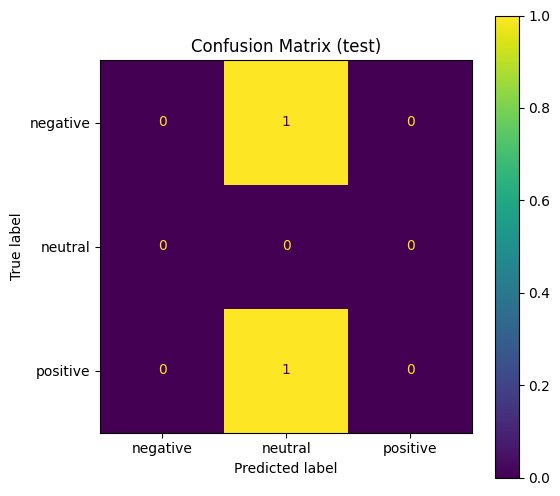

Saved pipeline to models/best_model.joblib


In [5]:
# Modeling: TF-IDF + Logistic Regression / Random Forest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.models import build_tfidf_vectorizer, train_logistic_regression, train_random_forest, evaluate_model, save_model

vectorizer = build_tfidf_vectorizer(max_features=5000)

# Fit vectorizer on train
X_train = vectorizer.fit_transform(train['text'])
X_val = vectorizer.transform(val['text'])
X_test = vectorizer.transform(test['text'])

# Train Logistic Regression
lr = train_logistic_regression(X_train, train['label'])
print('LR eval on val:', evaluate_model(lr, X_val, val['label']))

# Train Random Forest
rf = train_random_forest(X_train, train['label'])
print('RF eval on val:', evaluate_model(rf, X_val, val['label']))

# Choose best (by f1)
lr_metrics = evaluate_model(lr, X_val, val['label'])
rf_metrics = evaluate_model(rf, X_val, val['label'])
best = lr if lr_metrics['f1'] >= rf_metrics['f1'] else rf

# Evaluate on test
test_metrics = evaluate_model(best, X_test, test['label'])
print('Best model test metrics:', test_metrics)

# Confusion matrix
cm = confusion_matrix(test['label'], best.predict(X_test), labels=best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best.classes_)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title('Confusion Matrix (test)')
plt.show()

# Save the model: bundle vectorizer+model
import os
os.makedirs('models', exist_ok=True)
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vectorizer', vectorizer), ('clf', best)])
save_model(pipeline, 'models/best_model.joblib')
print('Saved pipeline to models/best_model.joblib')
